In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt


plt.style.use("fivethirtyeight")

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Parameters
n_samples = 1400    # number of points
n_features = 2     # 2D points
n_clusters = 3     # number of clusters
random_state = 42  # for reproducibility

# Generate the dataset
original_X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    cluster_std=1.0,  # spread of clusters
    random_state=random_state
)

In [3]:
X = original_X.copy()

In [4]:
print('X shape:', original_X.shape)
print('y shape:', y.shape)

X shape: (1400, 2)
y shape: (1400,)


# Exploring dataset

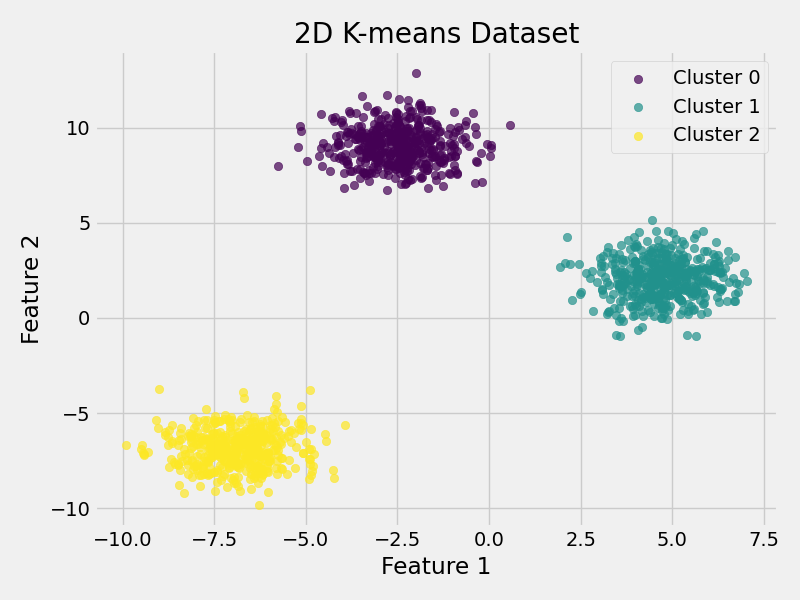

In [5]:
plt.figure(figsize=(8, 6))
# Use viridis colormap to match the second plot
import matplotlib.pyplot as plt
viridis = plt.get_cmap('viridis')
colors = [viridis(i/(n_clusters-1)) for i in range(n_clusters)]

for cluster in range(n_clusters):
    plt.scatter(
        original_X[y == cluster, 0],
        original_X[y == cluster, 1],
        color=colors[cluster],
        label=f'Cluster {cluster}',
        alpha=0.7,
    )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D K-means Dataset')
plt.legend()
plt.tight_layout()
plt.show()

# Implementing the model

## K-means explained simply

**Step 1: Initialization**  
K-means starts by picking **k centroids** (just some points in space).  

**Step 2: Assignment**  
Each data point looks around and says:  
*“Which centroid is closest to me?”*  
Then it joins that group.  

**Step 3: Update**  
The algorithm moves each centroid to the **average position** of the points assigned to it.  

**Step 4: Repeat**  
The points shuffle groups again based on these new centroids.  

This back-and-forth continues:  
**reassign points → move centroids → reassign points → move centroids**  

until the centroids stop moving or not shift that much(very small steps) (**convergence**).  

---

**Goal:**  
The algorithm is really trying to minimize the **total distance** between all points and their assigned centroids.  
This minimized value is the **cost function** it’s optimizing.  


## Centroid initialization

For now, we’ll pick 3 completely random points from the entire 3D space as our initial centroids. Think of it like dropping 3 dots anywhere inside a cube. Later, we’ll look at smarter ways to pick centroids that give better results.

In [6]:
centroids = np.array([ [2.5, 10], [5., -4.],[-7.5, 0]])
print(f"centroids:\n {centroids}")
print(f"centroids shape: {centroids.shape}")

centroids:
 [[ 2.5 10. ]
 [ 5.  -4. ]
 [-7.5  0. ]]
centroids shape: (3, 2)


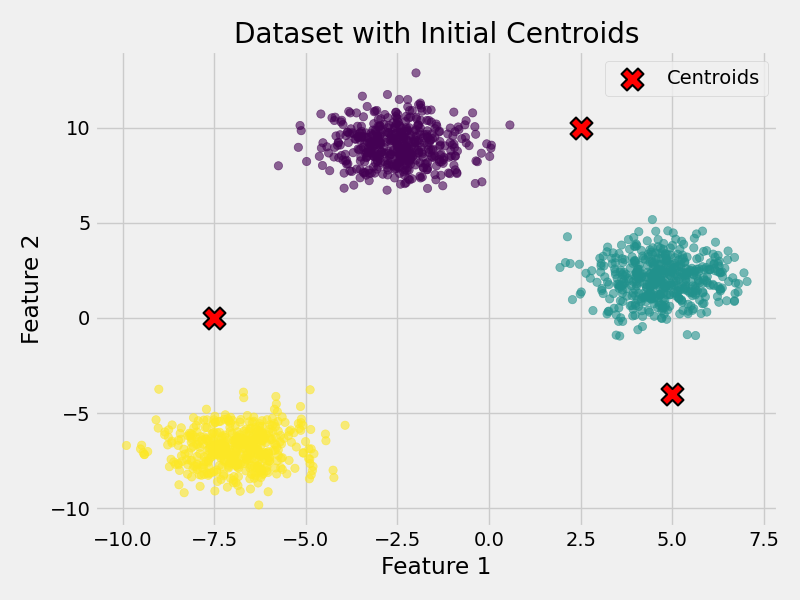

In [7]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    original_X[:, 0], original_X[:, 1],
    c=y, cmap='viridis', alpha=0.6, marker='o'
)

# Plot centroids with matching cluster colors
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='r',
    marker='X', s=250, edgecolor='black', linewidth=1.5,
    label='Centroids'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Initial Centroids')
plt.legend()
plt.tight_layout()
plt.show()

## Point-to-centroid assignment

In [8]:
def assign_to_centroids(X, cntr):
    """
    Assign each point in X to the closest centroid.

    Parameters
    ----------
    X : ndarray of shape (m, n)
        The set of points to work with, where m is the number of points 
        and n is the number of features.
    cntr : ndarray of shape (k, n)
        The set of k centroids.

    Returns
    -------
    c : ndarray of shape (m, )
        Array where c[i] holds the index of the centroid assigned to X[i].
    """

    # Compute squared distances between each point and each centroid,
    # then assign each point to the nearest centroid
    c = np.argmin(np.sum((cntr[np.newaxis, :, :] - X[:, np.newaxis, :])**2, axis=2), axis=1)

    return c


For more intuition about the broadcasting operations used in the code above, see the official NumPy documentation:  
[NumPy Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html#broadcasting)


* `cntr[np.newaxis, :, :]` creates a 3D array of shape `(1, k, n)`.  
* `X[:, np.newaxis, :]` creates a 3D array of shape `(m, 1, n)`.  
* Subtracting them (`cntr[np.newaxis, :, :] - X[:, np.newaxis, :]`) broadcasts to shape `(m, k, n)`, which represents the difference between each point and each centroid.  
* Squaring (`**2`) preserves the same shape `(m, k, n)`.  
* `np.sum(..., axis=2)` collapses the feature dimension, resulting in a `(m, k)` array of squared distances. Each element `t[i, j]` is the squared Euclidean distance between point `X[i]` and centroid `cntr[j]`.  
* `np.argmin(..., axis=1)` finds the index of the closest centroid for each point, producing a `(m,)` array.  


Let's use our function to assign each example in the dataset to one of the centroids

In [9]:
c = assign_to_centroids(X, centroids)
values, counts = np.unique(c, return_counts=True)

print(values)
print(counts)

[0 1 2]
[532 401 467]


## Moving the centroids

In [10]:
import numpy as np

def update_centroids(X, cntr, c):
    """
    Recompute the centroids based on the current point assignments.

    Parameters
    ----------
    X : ndarray of shape (m, n)
        The set of points, where m is the number of points
        and n is the number of features.
    cntr : ndarray of shape (k, n)
        The current set of k centroids.
    c : ndarray of shape (m, )
        Array of centroid indices, where c[i] is the index of
        the centroid assigned to point X[i].

    Returns
    -------
    new_cntr : ndarray of shape (k, n)
        The updated centroids, where each centroid is the mean of
        the points assigned to it.
    """

    new_cntr = np.zeros_like(cntr)

    for i in range(cntr.shape[0]):
        points = X[c == i]
        if len(points) > 0:
            new_cntr[i] = np.mean(points, axis=0)
        else:
            # Optional: handle empty cluster (no points assigned)
            # Keep the old centroid or reinitialize it
            new_cntr[i] = cntr[i]

    return new_cntr


Now we’ll implement the actual algorithm. But before that, we need a metric to evaluate how well our model is doing. For this, we’ll implement the cost function of K-means: the mean squared L2 norm of the difference between each point and its assigned centroid.

## The Cost Function 

The cost function for K-means is denoted by:

$$
J = \frac{1}{m} \sum_{i=1}^{m} \| x^{(i)} - \mu_{c^{(i)}} \|^2
$$

Where:  
- $m$ = number of data points  
- $x^{(i)}$ = the $i$-th data point  
- $c^{(i)}$ = the index of the centroid assigned to $x^{(i)}$  
- $\mu_{c^{(i)}}$ = the centroid assigned to point $x^{(i)}$


In [11]:
def cost_func(X, cntr, c):
    """
    Compute the K-means cost (mean squared distance to assigned centroids).

    Parameters
    ----------
    X : ndarray of shape (m, n)
        Array of data points, where m is the number of points and n is the number of features.
    cntr : ndarray of shape (k, n)
        Array of centroids, where k is the number of clusters.
    c : ndarray of shape (m, )
        Array of centroid indices assigned to each point in X.

    Returns
    -------
    j : float
        The mean squared distance between each point and its assigned centroid (K-means cost).
    """
    j = np.mean(np.sum((X - cntr[c])**2, axis=1))
    return j

In [12]:
cost_func(X, centroids, c)

np.float64(37.73422054164747)

## The K-means loop

Now we finally get to the actual algorithm. The steps are simple:

1. **Assign each point to its nearest centroid.**  
   Each point looks around and joins the group of the closest centroid.

2. **Move each centroid to the average position of its points.**  
   After all points are assigned, each centroid shifts to the center of its group.

These two steps repeat until the centroids stop moving significantly, meaning the algorithm has **converged**.

In [13]:
def K_means(X, cntr, iters=10, epsilon=0.005, verbose=True):
    """
    Run the K-means clustering algorithm on a dataset.

    Parameters
    ----------
    X : ndarray of shape (m, n)
        Dataset of m points with n features each.
    cntr : ndarray of shape (k, n)
        Initial centroids for the k clusters.
    iters : int, default=10
        Maximum number of iterations to run the algorithm.
    epsilon : float, default=0.005
        Convergence tolerance. If the decrease in cost between 
        consecutive iterations is less than or equal to epsilon, 
        the algorithm stops early.
    verbose : bool, default=True
        If True, prints progress information such as cost values and 
        centroid updates during training.

    Returns
    -------
    cntr : ndarray of shape (k, n)
        Final centroids after clustering.
    c : ndarray of shape (m, )
        Cluster assignment for each point in X.
    cost : list of float
        History of cost values (mean squared distances) at each iteration.
    
    Notes
    -----
    - Uses the helper functions `assign_to_centroids`, `update_centroids`, 
      and `cost_func`.
    - Stops early if the cost converges within the given epsilon tolerance.
    """
    # For visualization and stopping when converging
    print_count = max(1, iters // 10)

    c = assign_to_centroids(X, cntr)
    cost = [cost_func(X, cntr, c)]

    if verbose:
        print("Initial cost =", cost[0])
        print("Initial centroids :\n", cntr)
        print("#" * 30)

    for i in range(iters):
        c = assign_to_centroids(X, cntr)
        cntr = update_centroids(X, cntr, c)
        cost.append(cost_func(X, cntr, c))
        
        if verbose and i % print_count == 0: 
            print(f"Iteration {i+1}:\ncost = {cost[-1]:.6f}")
            print(f"Centroids:\n{cntr}\n")
            
        if cost[-2] - cost[-1] <= epsilon:
            if verbose:
                print(f"Converged at iteration {i+1}")
            break
            
    return cntr, c, cost

In [14]:
centroids, c, cost = K_means(X, centroids)

Initial cost = 37.73422054164747
Initial centroids :
 [[ 2.5 10. ]
 [ 5.  -4. ]
 [-7.5  0. ]]
##############################
Iteration 1:
cost = 5.086016
Centroids:
[[-1.64403999  8.3820312 ]
 [ 4.76117829  1.76757596]
 [-6.88410855 -6.80714442]]

Iteration 2:
cost = 1.931906
Centroids:
[[-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]
 [-6.88654126 -6.83889773]]

Iteration 3:
cost = 1.931906
Centroids:
[[-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]
 [-6.88654126 -6.83889773]]

Converged at iteration 3


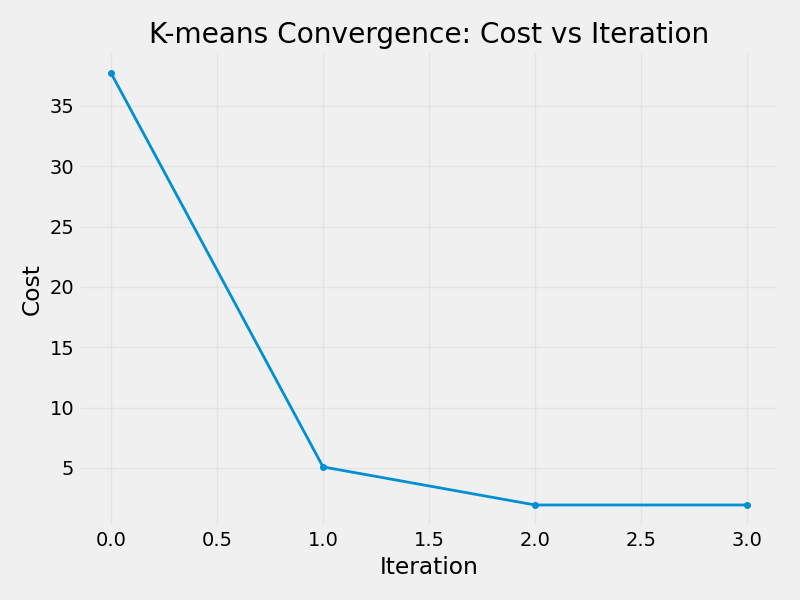

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(cost)), cost, marker='o', linewidth=2, markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('K-means Convergence: Cost vs Iteration')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

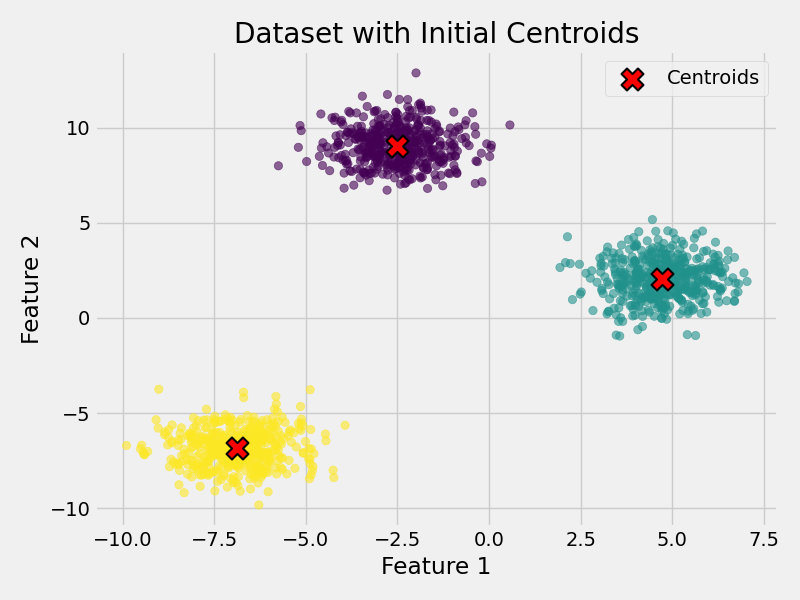

In [16]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    original_X[:, 0], original_X[:, 1],
    c=y, cmap='viridis', alpha=0.6, marker='o'
)

# Plot centroids with matching cluster colors
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    c='r',
    marker='X', s=250, edgecolor='black', linewidth=1.5,
    label='Centroids'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Initial Centroids')
plt.legend()
plt.tight_layout()
plt.show()

## Choosing the centroids

Previously, we picked some random centroids — and luckily, they worked out pretty well this time.  
But random choices don’t always play nice. Depending on where those first centroids land, the algorithm can end up with very different results.  
In fact, a poor initialization can lead to messy clusters or the algorithm getting stuck in a bad solution.  

### A Bad Initialization Example

Let’s see what happens when the centroids are initialized poorly.  

This demonstrates why random initialization can sometimes lead to bad results.  


In [17]:
bad_centroids = np.array([[5, 5], [5.2, 5.1], [10, 0]])

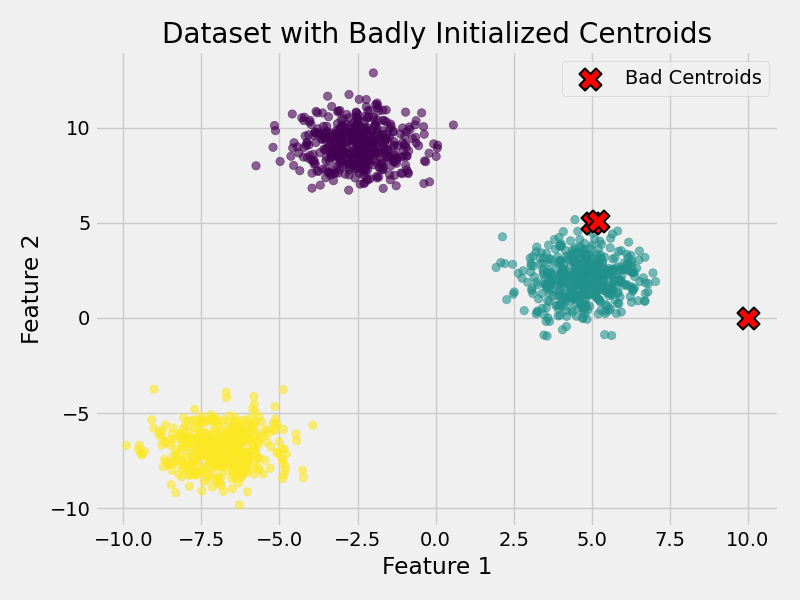

In [18]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    original_X[:, 0], original_X[:, 1],
    c=y, cmap='viridis', alpha=0.6, marker='o'
)

# Plot bad centroids
plt.scatter(
    bad_centroids[:, 0], bad_centroids[:, 1],
    c='r',
    marker='X', s=250, edgecolor='black', linewidth=1.5,
    label='Bad Centroids'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Badly Initialized Centroids')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
bad_centroids, bad_c, bad_cost = K_means(X, bad_centroids)

Initial cost = 122.76745339368235
Initial centroids :
 [[ 5.   5. ]
 [ 5.2  5.1]
 [10.   0. ]]
##############################
Iteration 1:
cost = 65.338281
Centroids:
[[-1.76788122  1.40765159]
 [ 6.28263563  3.20832296]
 [ 6.11890455  0.66964158]]

Iteration 2:
cost = 46.977412
Centroids:
[[-4.68454636  1.10726401]
 [ 4.74996184  2.90263444]
 [ 4.67068859  1.18836671]]

Iteration 3:
cost = 45.997121
Centroids:
[[-4.90900489  0.66191884]
 [ 3.76660959  3.99396701]
 [ 4.68454278  1.198558  ]]

Iteration 4:
cost = 24.155933
Centroids:
[[-6.18995396 -3.53371246]
 [-0.44164236  7.67190749]
 [ 4.83349889  1.60359413]]

Iteration 5:
cost = 1.931906
Centroids:
[[-6.88654126 -6.83889773]
 [-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]]

Iteration 6:
cost = 1.931906
Centroids:
[[-6.88654126 -6.83889773]
 [-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]]

Converged at iteration 6


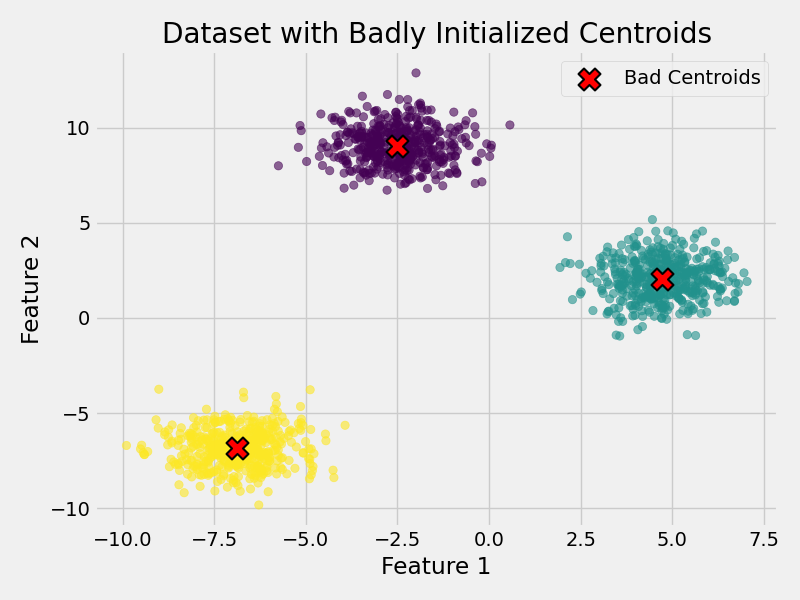

In [20]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    original_X[:, 0], original_X[:, 1],
    c=y, cmap='viridis', alpha=0.6, marker='o'
)

# Plot bad centroids
plt.scatter(
    bad_centroids[:, 0], bad_centroids[:, 1],
    c='r',
    marker='X', s=250, edgecolor='black', linewidth=1.5,
    label='Bad Centroids'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Badly Initialized Centroids')
plt.legend()
plt.tight_layout()
plt.show()

You might be thinking: *“But the algorithm still converged in the end, even with that "bad" initialization!”*  

That’s true — it did converge, but only because our dataset is well distributed, making it almost impossible to miss the correct clusters entirely.  

The key takeaway here isn’t about whether it converges, but **how efficiently** it gets there.  
A poor initialization can make the algorithm take longer and waste more resources before reaching the final solution.  

Let’s take a look at the learning curve to see this difference in action.


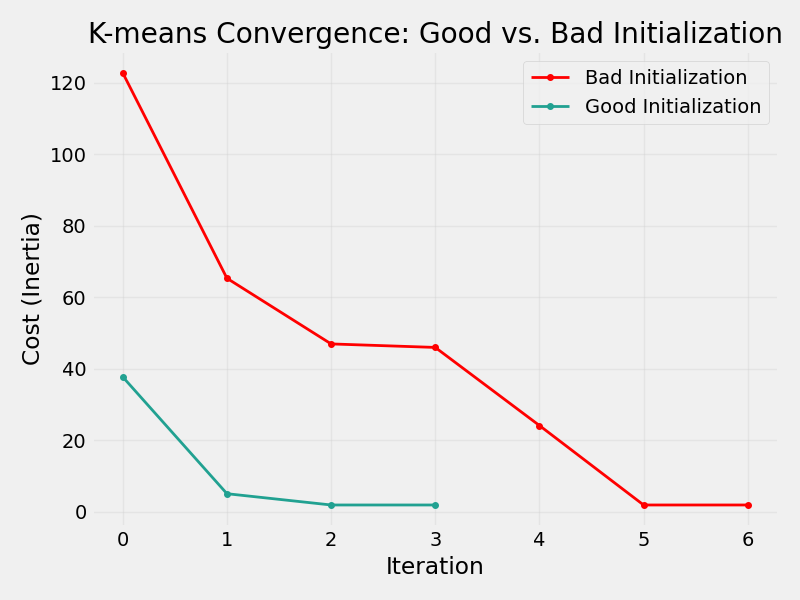

In [21]:
plt.figure(figsize=(8, 6))

# Plot bad initialization
plt.plot(
    range(len(bad_cost)), bad_cost,
    marker='o', linewidth=2, markersize=4,
    color='red', label='Bad Initialization'
)

# Plot good initialization
plt.plot(
    range(len(cost)), cost,
    marker='o', linewidth=2, markersize=4,
    color='#21a191', label='Good Initialization'
)

plt.xlabel('Iteration')
plt.ylabel('Cost (Inertia)')
plt.title('K-means Convergence: Good vs. Bad Initialization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


As you can clearly see, both runs do eventually converge in the end.  
But notice the difference: the green curve drops quickly and smoothly to its lowest cost,  
while the red curve struggles and takes much longer to get there.  

By iteration **3**, the green run has already stabilized at its minimum,  
whereas at that same point, the red run is still *fighting hard* to reduce its cost.

So yes—a **good choice of centroids** can save you a lot of time and resources.  

But that raises the question:  
**How do we actually choose a *good* set of centroids?**

Well, there are different strategies:  

1. **Random Initialization**  
   Just pick random points in the feature space as centroids (what we’ve been doing).  
   It’s simple, but risky—you might start with a terrible configuration.

2. **Forgy Method**  
   Instead of random coordinates, you randomly pick actual data points from the dataset as the starting centroids.  
   This usually works better than pure random guessing, but it can still select poor starting points (e.g., points too close to each other).  

3. **k-means++ Initialization**  
   This is the smarter approach most modern libraries (like scikit-learn) use.  
   It chooses the first centroid randomly, then picks subsequent centroids with probability proportional to the square of their distance from the nearest existing centroid.  
   This way, the starting centroids are well spread out, which often leads to much faster and more reliable convergence.  


### K-means++ Initialization

K-means++ is a very efficient way of initializing the centroids. It follows structured steps:  

1. **Choose the first centroid randomly**  
   Pick one data point from the dataset at random as the first centroid.  

2. **Compute distances**  
   For each remaining data point, calculate its distance to the **nearest chosen centroid**.  

3. **Select the next centroid using a probability distribution**  
   Choose the next centroid from the remaining points, where the probability of selecting a point is proportional to the **square of its distance** to the nearest centroid.  
   (This ensures that points farther away are more likely to be chosen.)  

4. **Repeat until k centroids are chosen**  



**Implementation:**

In [22]:
def K_pp(X, k):
    """
    Initialize centroids using the K-means++ algorithm.

    Parameters
    ----------
        X : ndarray of shape (m, n)
            Dataset of m points with n features each.
        k : int
            Number of centroids to initialize.
    
        Returns
    -------
    cntr : ndarray of shape (k, n)
        Initialized centroids chosen by the K-means++ procedure.
    """
    m, n = X.shape

    # 1. Pick the first centroid randomly
    random_index = np.random.choice(m)
    cntr = X[random_index][np.newaxis, :]  # shape (1, n)

    # 2. Pick the remaining centroids
    for _ in range(1, k):
        # distance from each point to its closest centroid
        distances = np.min(
            np.sum((X[:, np.newaxis, :] - cntr[np.newaxis, :, :]) ** 2, axis=2),
            axis=1
        )


        # probability distribution (proportional to squared distance)
        probability = distances / np.sum(distances)

        # choose new centroid index
        new_cntr_index = np.random.choice(m, p=probability)
        new_cntr = X[new_cntr_index][np.newaxis, :]  # keeps it a 2-D array

        # stack it with existing centroids
        cntr = np.vstack([cntr, new_cntr])


    return cntr

Initial cost = 1.931906165937143
Initial centroids :
 [[-6.88654126 -6.83889773]
 [-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]]
##############################
Iteration 1:
cost = 1.931906
Centroids:
[[-6.88654126 -6.83889773]
 [-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]]

Converged at iteration 1


TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

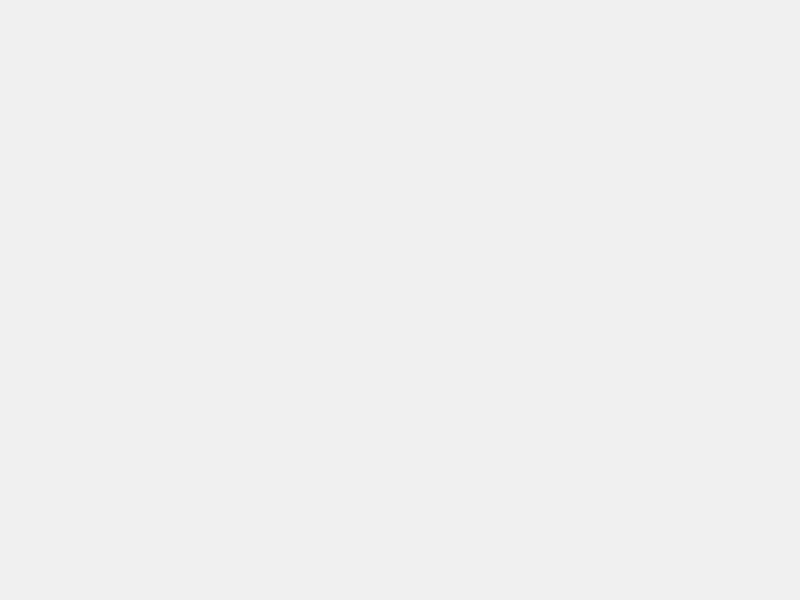

In [23]:
x = K_means(X, bad_centroids, iters=10)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
)

Let’s use our new initialization method and see how well it places the centroids.

We’ll go with k = 3 for now, and later we’ll explore a more systematic way of choosing the optimal number of clusters.

In [ ]:
centroids_kpp = K_pp(X, k=3)
centroids_kpp

array([[-5.2061751 , -5.53964854],
       [ 4.31953153,  2.39733563],
       [-3.45859651, 11.64666819]])

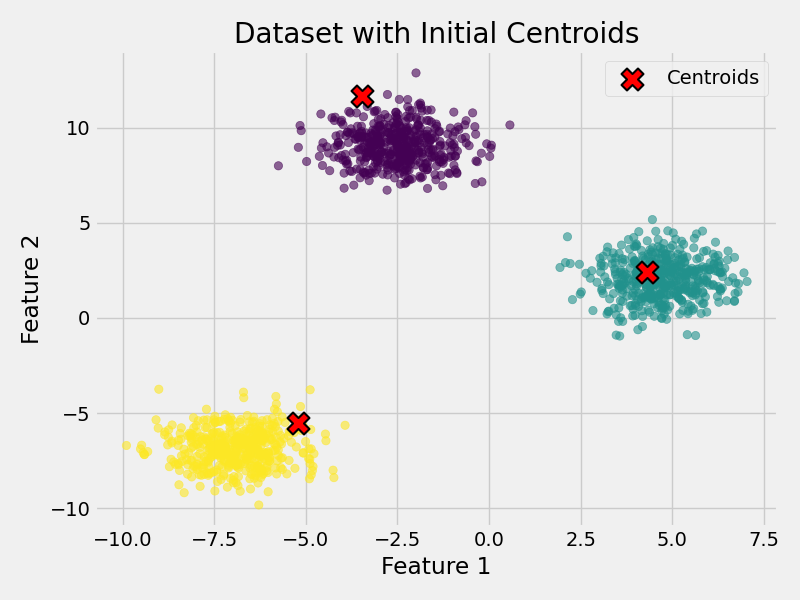

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    original_X[:, 0], original_X[:, 1],
    c=y, cmap='viridis', alpha=0.6, marker='o'
)

# Plot centroids with matching cluster colors
plt.scatter(
    centroids_kpp[:, 0], centroids_kpp[:, 1],
    c='r',  # cluster index 0,1,2
    marker='X', s=250, edgecolor='black', linewidth=1.5,
    label='Centroids'
)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Initial Centroids')
plt.legend()
plt.tight_layout()
plt.show()

You can see that each centroid is now much closer to its cluster, which should make K-means run more efficiently. Let’s test that out.

Before that, let’s make a few small changes to our `K_means` function so we can plug in the `K_pp` initialization.

In [ ]:
def K_means(X, cntr=None, k=1, iters=10, epsilon=0.005, verbose=True):
    """
    Run the K-means clustering algorithm on a dataset.

    Parameters
    ----------
    X : ndarray of shape (m, n)
        Dataset of m points with n features each.
    cntr : ndarray of shape (k, n), default=None
        Initial centroids for the k clusters.
        If None, the algorithm initializes centroids using the K-means++ algorithm.
    k : int, default=1
        Number of clusters.
    iters : int, default=10
        Maximum number of iterations to run the algorithm.
    epsilon : float, default=0.005
        Convergence tolerance. If the decrease in cost between 
        consecutive iterations is less than or equal to epsilon, 
        the algorithm stops early.
    verbose : bool, default=True
        If True, prints progress information such as cost values and 
        centroid updates during training.

    Returns
    -------
    cntr : ndarray of shape (k, n)
        Final centroids after clustering.
    c : ndarray of shape (m, )
        Cluster assignment for each point in X.
    cost : list of float
        History of cost values (mean squared distances) at each iteration.
    
    Notes
    -----
    - Uses the helper functions `assign_to_centroids`, `update_centroids`, 
      and `cost_func`.
    - Stops early if the cost converges within the given epsilon tolerance.
    """

    if k <= 0:
        print('Error, K must be greater than 0')
        return -1
    # For visualization and convergence checks
    print_count = max(1, iters // 10)

    # Initialize centroids
    if cntr is None:
        cntr = K_pp(X=X, k=k)

    # First assignment and initial cost
    c = assign_to_centroids(X, cntr)
    cost = [cost_func(X, cntr, c)]

    if verbose:
        print("Initial cost =", cost[0])
        print("Initial centroids:\n", cntr)
        print("#" * 30)

    for i in range(iters):
        c = assign_to_centroids(X, cntr)
        cntr = update_centroids(X, cntr, c)
        cost.append(cost_func(X, cntr, c))
        
        if verbose and i % print_count == 0: 
            print(f"Iteration {i+1}:\ncost = {cost[-1]:.6f}")
            print(f"Centroids:\n{cntr}\n")
            
        if abs(cost[-2] - cost[-1]) <= epsilon:
            if verbose:
                print(f"Converged at iteration {i+1}")
            break
            
    return cntr, c, cost


Let’s now run it on our dataset without giving it any centroids. For now, we’ll just stick with `k=3`.

In [ ]:
centroids_kpp, c, K_pp_cost = K_means(X, k=3)

Initial cost = 2.832966245305521
Initial centroids:
 [[-3.22450133  9.69388388]
 [ 5.42567899  2.39862725]
 [-7.10822711 -7.87445897]]
##############################
Iteration 1:
cost = 1.931906
Centroids:
[[-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]
 [-6.88654126 -6.83889773]]

Iteration 2:
cost = 1.931906
Centroids:
[[-2.50469163  9.04857869]
 [ 4.70780245  2.03499402]
 [-6.88654126 -6.83889773]]

Converged at iteration 2


Now, let’s compare the performance with our previous two initializations: the manually chosen one, and K-means++.

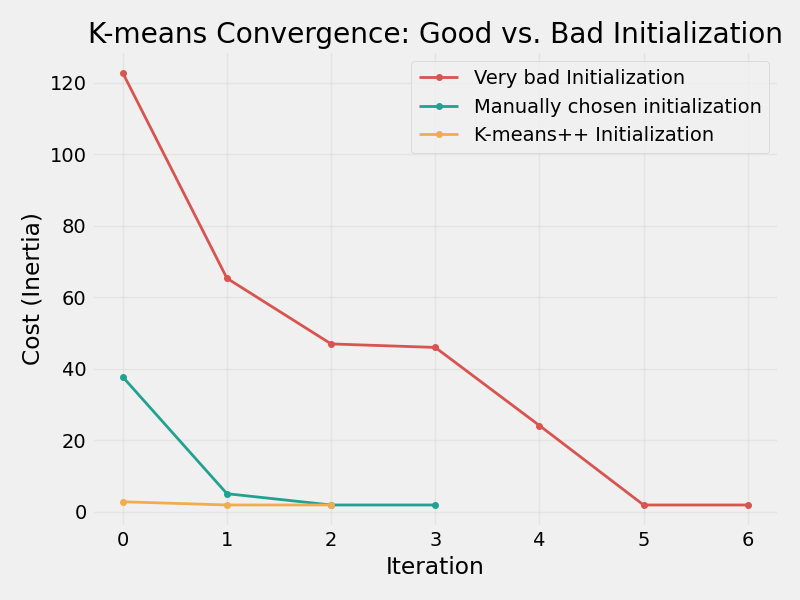

In [ ]:
plt.figure(figsize=(8, 6))

# Plot bad initializations
plt.plot(
    range(len(bad_cost)), bad_cost,
    marker='o', linewidth=2, markersize=4,
    color='#d9534f', label='Very bad Initialization'
)

plt.plot(
    range(len(cost)), cost,
    marker='o', linewidth=2, markersize=4,
    color='#21a191', label='Manually chosen initialization'
)


# Plot good initialization

plt.plot(
    range(len(K_pp_cost)), K_pp_cost,
    marker='o', linewidth=2, markersize=4,
    color='#f0ad4e', label='K-means++ Initialization'
)


plt.xlabel('Iteration')
plt.ylabel('Cost (Inertia)')
plt.title('K-means Convergence: Good vs. Bad Initialization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


You can clearly see the difference here. With **bad initialization** (red), the algorithm struggles for several iterations and wastes time before eventually finding decent centroids. The **hand-chosen initialization** (teal) does better but still depends on luck and intuition. In contrast, **K-means++ (gold)** starts with centroids that are already well-placed. As a result, the cost (inertia) drops sharply and stabilizes almost immediately.

This shows why **K-means++ is the standard choice** - it gives the algorithm a head start by spreading out the centroids intelligently, leading to faster convergence and better clustering in practice.


Check out these visual explanations if you want intuition beyond equations:  

- [K Means++ Algorithm | solved example](https://youtu.be/z2yncM2HE6M?si=CeqfEKAuEn1iy99K)  
- [K-Means++ Centroid Initialization](https://youtu.be/4qJWhvFQb9g?si=idp9JEXoyhyub0L8)  
- [K means++ initial center selection visualization](https://youtu.be/efKGmOH4Y_A?si=-JiemN5ZPBVNGAwu)  

They’ll help you *see* why centroids that are well spread out tend to lead to faster convergence and more stable clustering.


## Choosing K(number of clusters)

So far, we’ve been fixing `K=3` because it was clear that our dataset naturally had three clusters.  
But in more complex datasets, the right choice of `K` isn’t always so obvious.  

This choice is crucial:  
- If K is too small, very different points may be forced into the same cluster.  
- If K is too large, clusters can split unnecessarily and lose meaning.  

In practice, there are several strategies to guide us, such as the **Elbow Method**, the **Silhouette Score**, or simply using domain knowledge about the data.  

Let’s begin with the Elbow Method to build some intuition.


### Elbow Method

The **Elbow Method** helps choose a good \(K\) by plotting the cost (sum of squared distances to centroids) against different values of \(K\). You’ll typically see the cost drop sharply at first, then start flattening. The “elbow” — the point where the decline becomes less steep — is a good guess for the optimal \(K\).

See this video for more intuition: [*The Elbow Method Explained in Less than 5 minutes*](https://youtu.be/ht7geyMAFfA?si=Du5eIl3ojSlfIzen)  

Let's plot the cost for K varying from 1 to 20



In [ ]:
K_cost = list()
number_of_k = 20
for k in range(1, number_of_k + 1):
    centr, c_, cos = K_means(X, k=k,verbose=False)

    K_cost.append(cos[-1])

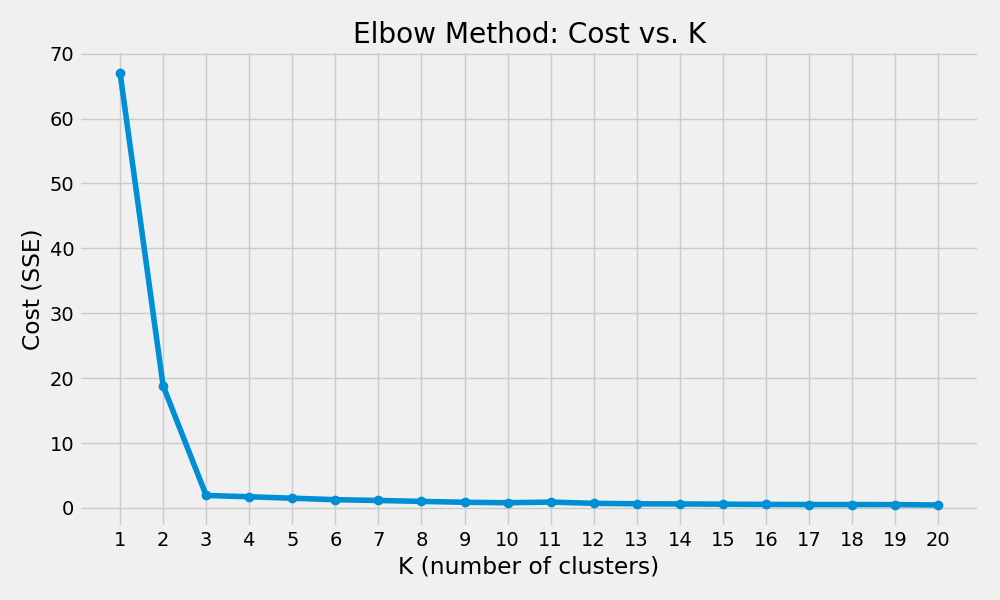

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, number_of_k + 1), K_cost, marker='o', linestyle='-')
plt.xlabel("K (number of clusters)")
plt.ylabel("Cost (SSE)")
plt.title("Elbow Method: Cost vs. K")
plt.grid(True)

# force x-axis to show only integer ticks
plt.xticks(range(1, number_of_k + 1))
plt.tight_layout()
plt.show()

The graph shows how the clustering cost (SSE) decreases as we increase the number of clusters K. At first, adding more clusters reduces the cost significantly, but after a certain point the improvements become very small.

Here, you can see a sharp drop in cost until around **K = 3**, after which the curve flattens. That “bend” in the curve is called the **elbow**, and it’s our best guess for the optimal number of clusters.

The intuition is simple:

- Before the elbow, each new cluster adds real value (big drop in cost).
- After the elbow, new clusters don’t improve much — they just overcomplicate the model.

So from this graph, the elbow at **K = 3** confirms that 3 clusters is a good choice for this dataset.


### Silhouette Score

The **silhouette score** measures how well a point fits within its cluster compared to other clusters.  

For a point $i$:  
$$
s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}}
$$

where:  
- $a(i)$ = average distance from $i$ to all other points in the same cluster (cohesion).  
- $b(i)$ = minimum average distance from $i$ to points in any other cluster (separation).  

The score satisfies:  
$$
-1 \leq s(i) \leq 1
$$

**Interpretation:**  
- $s(i) \approx 1$ → point is well-clustered.  
- $s(i) \approx 0$ → point lies on or near the boundary between clusters.  
- $s(i) < 0$ → point may be misclassified.  

**Steps:**  
1. Calculate the silhouette score for every point.  
2. Compute the silhouette score of each cluster by averaging the scores of its points.  
3. Compute the overall mean silhouette score across all clusters.  

See this video if you want a visual walk-through:  
[*Silhouette Score for clustering Explained*](https://youtu.be/_jg1UFoef1c?si=kT6PI9a-UgdcPPPS)


In [ ]:
def silhouette(X, cntr, c=None):
    """
    Compute the mean silhouette score for a clustering.

    The silhouette score measures how similar each point is to its own cluster
    (cohesion) compared to other clusters (separation).

    Parameters
    ----------
    X : ndarray of shape (m, n)
        The dataset with m samples and n features.
    cntr : ndarray of shape (k, n)
        The centroids of the k clusters.
    c : ndarray of shape (m,), optional
        Precomputed cluster assignments for each sample. If None, assignments
        will be computed using `assign_to_centroids`.

    Returns
    -------
    float
        The mean silhouette score over all samples. Ranges between -1 and 1:
        - Values close to 1 indicate well-clustered points.
        - Values close to 0 indicate points on cluster boundaries.
        - Values close to -1 indicate possible misclassification.
    """
    m, n = X.shape                 # m = number of samples, n = features
    k = cntr.shape[0] # k = number of clusters

    if k <= 1:
        raise ValueError("Silhouette score is undefined for less than 2 clusters. Please use k >= 2.")
        
    if c is None:
        c = assign_to_centroids(X, cntr)  # assign clusters if not provided
    
    a_i = np.zeros((m,))           # intra-cluster distance for each sample
    b_i = np.full((m,), np.inf)    # nearest-cluster distance for each sample

    # Full pairwise distance matrix: shape (m, m)
    distances = np.sqrt(np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=2))
    
    # Loop over each cluster
    for i in range(k):
        cluster_mask = (c == i)              # boolean mask for points in cluster i
        cluster_size = np.sum(cluster_mask)  # number of points in cluster i

        if cluster_size <= 1:                # singletons → silhouette = 0
            a_i[cluster_mask] = 0
            continue
            
        # Compute average distance of each point in cluster i to other points in the same cluster
        a_i[cluster_mask] = np.sum(distances[cluster_mask][:, cluster_mask], axis=1) / (cluster_size - 1)
        
        # Compare to all other clusters to compute b_i
        for j in range(k):
            if j == i: 
                continue  # skip same cluster
            outer_cluster_mask = (c == j)    # mask for cluster j

            if np.any(outer_cluster_mask):   # ignore empty clusters
                # Distances between points in cluster i and points in cluster j
                inter_distances = distances[cluster_mask][:, outer_cluster_mask]
                # Average distance from each point in i to cluster j
                b_candidate = np.mean(inter_distances, axis=1)
                # Keep the minimum across all other clusters
                b_i[cluster_mask] = np.minimum(b_i[cluster_mask], b_candidate)

    # Compute silhouette score for each point
    s_i = (b_i - a_i) / np.maximum(a_i, b_i)
    # Return the mean silhouette score across all samples
    return np.mean(s_i)


In [ ]:
silhouette(X, centroids)

np.float64(0.8441597952665442)

Let's try to see silhouette scores for different values of k.

> **Note:** The Silhouette score is undefined for `k <= 1`.  
> - With **k = 1**, all points belong to the same cluster, so there’s no "other cluster" to compare against (no separation).  
> - With **k = 0**, clustering is meaningless.  
>
> Therefore, the Silhouette method requires **at least 2 clusters** to make sense.  

So all we need to do now is to make the loop start from 2.

In [ ]:
sill = list()
k = 20
for i in range(2, k + 1):
    centr , _, _ = K_means(X, k=i, verbose=False)
    temp = silhouette(X, centr)
    sill.append(temp)

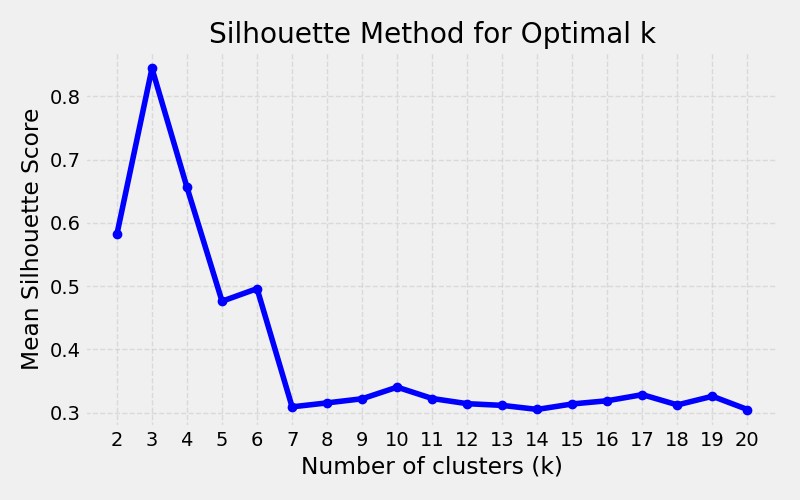

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, k + 1), sill, marker='o', linestyle='-', color='b')
plt.xticks(range(2, k + 1))  # force integer ticks on x-axis
plt.xlabel("Number of clusters (k)")
plt.ylabel("Mean Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The silhouette score provides a clear, quantitative way to evaluate clustering quality across different values of K. Unlike the elbow method (which only measures compactness), the silhouette score accounts for both how tight clusters are internally and how well-separated they are from each other.

Looking at the plot above, we can see a dramatic peak at **K = 3**, with a silhouette score of approximately 0.86. This is excellent—scores above 0.7 indicate strong, well-defined clusters.

Here's what's happening at different K values:

- **K = 2**: Score around 0.71. While decent, we're forcing three natural clusters into just two groups, creating unnecessary overlap.

- **K = 3**: Score peaks at ~0.86. This confirms what we suspected—the dataset naturally contains three distinct, well-separated clusters. Points are close to their cluster centers and far from other clusters.

- **K = 4 to 6**: Sharp decline to ~0.66. We're starting to split natural clusters artificially, which weakens both cohesion (points less similar within clusters) and separation (clusters closer together).

**Why is K = 3 optimal?**

The silhouette method effectively validates our earlier elbow method result. The peak at K = 3 tells us this is where we achieve the best balance: clusters are internally compact (low intra-cluster distance) while being well-separated from each other (high inter-cluster distance).

The steep drop after K = 3 is a strong signal that adding more clusters doesn't reveal meaningful structure—it just fragments the natural groupings. This makes the silhouette method particularly valuable: it doesn't just show when we're adding unnecessary complexity, it quantifies the degradation in clustering quality.

In practice, you should look for:
1. The highest silhouette score (best overall quality)
2. A clear peak followed by decline (indicating natural structure)
3. Scores above 0.5 (generally acceptable clustering)

For this dataset, all three criteria point unambiguously to **K = 3** as the optimal choice.